In [17]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')

# Import Google Reviews and Trip Advisor data
file_path_1 = "../data/google_reviews/google reviews cleaned df_text.xlsx"
file_path_2 = "../data/TripAdvisor_reviews/raw_data/tripadvisor.csv"
df1 = pd.read_excel(file_path_1)
df2 = pd.read_csv(file_path_2)

# Select specific columns we are interested in
df1 = df1[['rating', 'visited_on', 'review_text', 'original_language']]

df2 = df2[['Rating', 'Stay Date', 'Review Text', 'Language']]

# Ensure both datasets have consistent column names
df2 = df2.rename(columns = {'Rating' : 'rating',
                 'Review Text' : 'review_text',
                 'Language' : 'original_language'})

df2['Stay Date'] = pd.to_datetime(df2['Stay Date'])

df2['visited_on'] = df2['Stay Date'].apply(lambda x: "Weekend" if pd.notna(x) and x.weekday() >= 5 else "Weekday")

df2 = df2[['rating', 'visited_on', 'review_text', 'original_language']]

# Merging both data sets
df = pd.concat([df1, df2], ignore_index=True)

We begin pre-processing the google reviews with text for sentimental analysis. We set all the texts to lowercase, keeping only alphanumeric characters and removing stopwords. We also do one hot encodding to the visited on column with 0 representing Weekday and 1 representing weekend. Finally, we drop unnecessary columns.

In [2]:
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
additional_words = {'universal', 'uss', 'studio', 'singapore', 'theme', 'park'}
stop_words.update(additional_words)
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Lowercase, remove special characters, and extra spaces."""
    text = text.lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only alphanumeric characters
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Remove stopwords + Lemmatization
    return ' '.join(words)

df['review_text'] = df['review_text'].apply(clean_text)
df['is_english_speaker'] = df['original_language'].apply(lambda x: 1 if x == 'en' else 0)
df['visited_on'] = df['visited_on'].apply(lambda x: 0 if x == 'Weekday' else 1)
df['rating'] = pd.to_numeric(df['rating'])


print(df.columns)

Index(['rating', 'visited_on', 'review_text', 'original_language',
       'is_english_speaker'],
      dtype='object')


Let's preview the dataset.

In [3]:
print(df.head())

   rating  visited_on                                        review_text  \
0       5           0  great day studio visited june sunny hot highly...   
1       5           0  studio popular tourist destination offering fu...   
2       5           0                           amazing modern beautiful   
3       5           0  one go park also osaka japan u california flor...   
4       5           0  bit old still fun recommended play 16001900 pe...   

  original_language  is_english_speaker  
0                en                   1  
1                id                   0  
2                id                   0  
3                en                   1  
4                th                   0  


Let's segment the reviews into 5 segments based on 'Stars'.

C:\Users\HopeE\AppData\Local\Temp\ipykernel_6584\391236939.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')


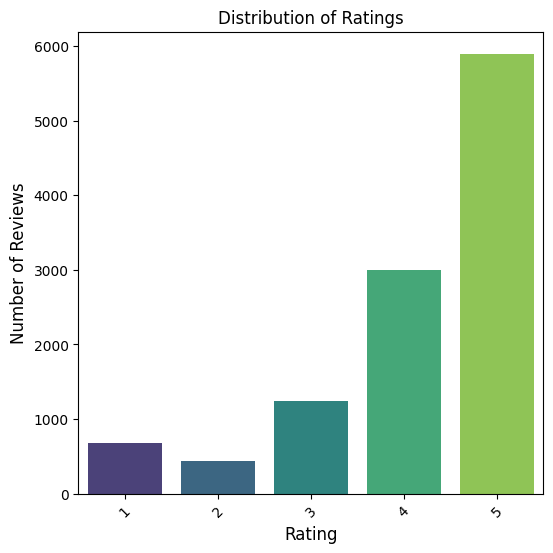

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each rating
rating_counts = df['rating'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(6, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')

# Adding labels and title
plt.title('Distribution of Ratings', fontsize=12)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.show()

Let's conduct sentimental analysis to better understand the tone behind the text data.

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']  # The compound score indicates overall sentiment

df['sentiment'] = df['review_text'].apply(get_sentiment)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))
df['sentiment_label'].value_counts()

sentiment_label
positive    8485
neutral     1819
negative     956
Name: count, dtype: int64

We follow up by plotting the sentiment label against the stars of the review.

C:\Users\HopeE\AppData\Local\Temp\ipykernel_6584\3653652341.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment_label', y='rating', data=df, palette='viridis')


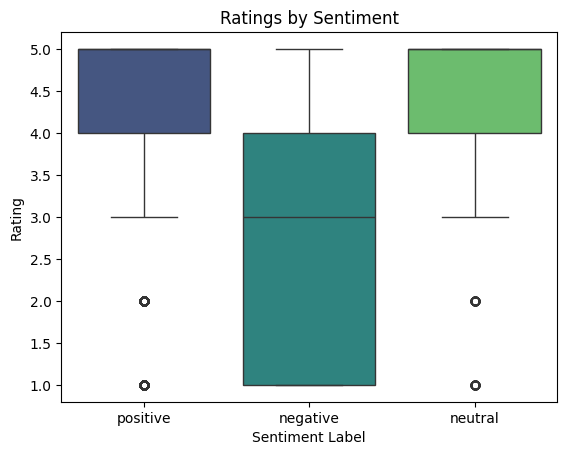

In [6]:
sns.boxplot(x='sentiment_label', y='rating', data=df, palette='viridis')
plt.title('Ratings by Sentiment')
plt.xlabel('Sentiment Label')
plt.ylabel('Rating')
plt.show()

Let's take a look at what are the most common keywords in reviews with negative sentiment label or with less than good ratings (i.e. less than equal to 3/5).

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create bigrams for filtered reviews
vectorizer = CountVectorizer(ngram_range = (2,2))
negative_reviews = df[(df['sentiment_label'] == 'negative') | (df['rating'] <= 3)]['review_text']

# Create the term-document matrix for negative reviews
negative_ngrams = vectorizer.fit_transform(negative_reviews)

# Convert to a DataFrame
word_counts = pd.DataFrame(
    negative_ngrams.toarray(), 
    columns=vectorizer.get_feature_names_out()
)

# Sum the occurrences of each n-gram
word_frequencies = word_counts.sum().sort_values(ascending=False)

# Get the top N unigrams and bigrams
top_n = 10  # Change this number as needed
print("Most Common Words and Phrases:")
print(word_frequencies.head(top_n))


rating                  int64
visited_on              int64
review_text            object
original_language      object
is_english_speaker      int64
sentiment             float64
sentiment_label        object
dtype: object
Most Common Words and Phrases:
express pas         507
waiting time        338
wait time           251
roller coaster      206
express ticket      206
long queue          171
transformer ride    164
fast pas            120
express pass        110
buy express         106
dtype: int64


We have identified the key causes of guest complaints. The most common causes seem to be 'Waiting time', 'Long queue' and 'express pass'. We can define some high-risk keywords based on these common causes alongside other risk-related keywords. We map these keywords to every review to acquire the frequency of these keywords in reviews. We then create a risk rating based on a weighted formula based on rating, sentiment and keyword frequency. Using the scaled risk rating, we create a pre-determined threshold to label reviews as low, medium or high risk and use that as our target variable. Since most of the reviews are positive (4-5 stars), we would expect to see relatively less 'high risk' labels as compared to 'medium risk' and 'low risk'.

In [8]:
# Define high-risk keywords

from sklearn.preprocessing import MinMaxScaler


high_risk_keywords = ['accident', 'injury', 'unsafe', 'dangerous', 'broken', 'malfunction', 'waste',
                        'sick', 'poisoning', 'crowded', 'long wait', 'unhygienic', 'fell', 'hurt',
                        'defective', 'improper', 'hazard', 'inadequate', 'negligence', 'danger', 'waiting',
                        'bad', 'terrible', 'disappointing', 'angry', 'wait', 'long', 'issue', 'technical'
                        ]

def engineer_features(df, keywords):
    featured_df = df.copy()

    # Create feature for review length (might indicate detail of complaint)
    featured_df['review_length'] = featured_df['review_text'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
    
    for keyword in keywords:
        featured_df[f'has_{keyword}'] = featured_df['review_text'].apply(
            lambda x: 1 if isinstance(x, str) and keyword in x.lower() else 0
        )
    
    # Create a complaint keyword count feature
    featured_df['complaint_keyword_count'] = featured_df[[f'has_{keyword}' for keyword in keywords]].sum(axis=1)

    scalar = MinMaxScaler()
    
    # Remove certain reviews which are just empty space
    featured_df = featured_df[featured_df['review_length'] != 0]
    featured_df.reset_index(drop=True, inplace=True)


    # Weights for risk rating tabulation
    w = [0.7, 0.5, 0.3]

    featured_df['risk_rating'] = (w[0] * (5 - featured_df['rating'])) + (w[1] * (1-featured_df['sentiment'])) + (w[2] * (featured_df['complaint_keyword_count']/featured_df['review_length']))
    featured_df['risk_rating'] = scalar.fit_transform(featured_df[['risk_rating']]) 
    
    featured_df['risk_label'] = featured_df['risk_rating'].apply(lambda x: 'low' if x<0.3 else ('medium' if x<0.7 else 'high'))

    # Define features and target
    X = featured_df[['rating', 'visited_on', 'review_text', 'sentiment', 'is_english_speaker']]
    y = featured_df['risk_label']
    
    return X, y

X, y = engineer_features(df, high_risk_keywords)
 
y.value_counts()

risk_label
low       7916
medium    2089
high       820
Name: count, dtype: int64

We transform the text into numerical format before fitting into our Machine Learning models. We will use TF-IDF(Term Frequency-Inverse Document Frequency) to convert our review text data into vectors.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Initialise the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=3, stop_words='english')
text_vectors = tfidf_vectorizer.fit_transform(X['review_text'])

# Convert text vectors to dense array and create a DataFrame
text_df = pd.DataFrame(
            text_vectors.toarray(), 
            columns=[f'tfidf_feature_{i}' for i in range(text_vectors.shape[1])]
        )
# Fit and transform the cleaned review text

#print(f"length of vectorized_df : {vectorized_text}")

X_tfidf = pd.concat([X, text_df], axis = 1)
X_tfidf = X_tfidf.drop(columns=['review_text'])

# Split the data into training set and test set
X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


Since some review texts tend to be relatively short, TF-IDT may not be very useful. We will instead use sentence embedding by using a pre-trained sentence embedding model BERT to capture semantics and syntax of review texts.

In [10]:
from sentence_transformers import SentenceTransformer

# Load Sentence-BERT model
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Convert embeddings to DataFrame
X_sbert = sbert_model.encode(X['review_text'].tolist())
X_sbert_df = pd.DataFrame(X_sbert, 
                          index = X.index,
                          columns=[f'sbert_feature_{i}' for i in range(X_sbert.shape[1])]
)

# Merge embeddings back with original data
X_sbert = pd.concat([X, X_sbert_df], axis = 1)
X_sbert = X_sbert.drop(columns = ['review_text'])

X_sbert_train, X_sbert_test, y_sbert_train, y_sbert_test = train_test_split(X_sbert, y, test_size=0.2, random_state = 43)


c:\Users\HopeE\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Firstly, we use Logistic Regression for a simple method to evaluate our data.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

def logs_regression(X_train, X_test, y_train, y_test):
# Split the data

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate model performance
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Display the classification report
    print(classification_report(y_test, y_pred))


tfidf_lr = logs_regression(X_tfidf_train, X_tfidf_test, y_train, y_test)

tfidf_lr

Accuracy: 1.00
              precision    recall  f1-score   support

        high       0.98      0.99      0.98       162
         low       1.00      1.00      1.00      1561
      medium       0.99      0.99      0.99       442

    accuracy                           1.00      2165
   macro avg       0.99      0.99      0.99      2165
weighted avg       1.00      1.00      1.00      2165



We attempt a similar method using Decision Trees.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree(X_train, X_test, y_train, y_test):

    dt = DecisionTreeClassifier(max_depth=5)
    dt_model = dt.fit(X_train,y_train)
 
    print('Decision Tree accuracy for training set: %f' % dt_model.score(X_train, y_train))
    print('Decision Tree accuracy for test set: %f' % dt_model.score(X_test, y_test))

    return dt_model

tfidf_dt = decision_tree(X_tfidf_train, X_tfidf_test, y_train, y_test)

tfidf_dt

Decision Tree accuracy for training set: 0.999423
Decision Tree accuracy for test set: 0.999076


DecisionTreeClassifier(max_depth=5)

Let's test our models with BERT sentence embedding.

In [13]:
sbert_lr = logs_regression(X_sbert_train, X_sbert_test, y_sbert_train, y_sbert_test)

sbert_lr

Accuracy: 1.00
              precision    recall  f1-score   support

        high       0.99      1.00      1.00       167
         low       1.00      1.00      1.00      1587
      medium       0.99      0.99      0.99       411

    accuracy                           1.00      2165
   macro avg       1.00      1.00      1.00      2165
weighted avg       1.00      1.00      1.00      2165



In [14]:
sbert_dt = decision_tree(X_sbert_train, X_sbert_test, y_sbert_train, y_sbert_test)

sbert_dt

Decision Tree accuracy for training set: 0.999307
Decision Tree accuracy for test set: 0.999076


DecisionTreeClassifier(max_depth=5)

In order to utilize new feedback data from guests in our model, we create a function to process the raw data.

In [15]:
import datetime
# Helper function to apply feature engineering to new data
def process_guest_data(new_data, type):
    """
    Apply the same feature engineering to new data as was done during training
    """
    # Create a copy
    processed_df = new_data.copy()

    processed_df['review_text'] = processed_df['review_text'].apply(clean_text)

    time_now = datetime.datetime.now()

    processed_df['visited_on'] = (lambda x: 1 if x.weekday() >= 5 else 0)(time_now)

    processed_df['is_english_speaker'] = processed_df['original_language'].apply(lambda x: 1 if x == 'en' else 0)

    processed_df['sentiment'] = processed_df['review_text'].apply(get_sentiment)
    
    # Create feature for review length
    processed_df['review_length'] = processed_df['review_text'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
    
    # Extract high-risk keywords
    high_risk_keywords = ['accident', 'injury', 'unsafe', 'dangerous', 'broken', 'malfunction', 'waste',
                        'sick', 'poisoning', 'crowded', 'long wait', 'unhygienic', 'fell', 'hurt',
                        'defective', 'improper', 'hazard', 'inadequate', 'negligence', 'danger', 'waiting',
                        'bad', 'terrible', 'disappointing', 'angry', 'wait', 'long', 'issue', 'technical',
                        'time', 'queue'
                        ]
    
    for keyword in high_risk_keywords:
        processed_df[f'has_{keyword}'] = processed_df['review_text'].apply(
            lambda x: 1 if isinstance(x, str) and keyword in x.lower() else 0
        )
    
    # Create a complaint keyword count feature
    processed_df['complaint_keyword_count'] = processed_df[[f'has_{keyword}' for keyword in high_risk_keywords]].sum(axis=1)

    
    output_df = processed_df[['rating', 'visited_on', 'sentiment', 'is_english_speaker']]

    if type == 'tfidf':
        # Initialise the TF-IDF vectorizer
        tfidf_vectorizer = TfidfVectorizer(max_features=3, stop_words='english')

        text_vectors = tfidf_vectorizer.fit_transform(processed_df['review_text'])

        # Convert text vectors to dense array and create a DataFrame
        text_df = pd.DataFrame(
                    text_vectors.toarray(), 
                    columns=[f'tfidf_feature_{i}' for i in range(text_vectors.shape[1])]
        )

        result_df = pd.concat([output_df, text_df], axis = 1)

    elif type == 'bert':
        # Load Sentence-BERT model
        sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

        # Convert embeddings to DataFrame
        X_sbert = sbert_model.encode(processed_df['review_text'].tolist())
        X_sbert_df = pd.DataFrame(X_sbert, 
                                columns=[f'sbert_feature_{i}' for i in range(X_sbert.shape[1])]
            )

        # Merge embeddings back with original data
        result_df = pd.concat([output_df, X_sbert_df], axis = 1)
        
    return result_df


Let's test our algorithm with some guest input data.

In [16]:
from langdetect import detect

rating = input("How satisfied is your experience at USS so far? On a scale of 1-5: ")
feedback_text = input("What seems to be the issue you're facing?: ")
language = detect(feedback_text)

raw_data = {
    "rating" : [rating],
    "review_text" : feedback_text,
    "original_language" : language
}

raw_data = pd.DataFrame(raw_data)
raw_data["rating"] = pd.to_numeric(raw_data["rating"], errors="coerce")


guest_data_tfidf = process_guest_data(raw_data, 'tfidf')
guest_data_bert = process_guest_data(raw_data, 'bert')


print(f"Risk Level by TFIDF Decision Tree : {tfidf_dt.predict(guest_data_tfidf)[0]}")
print(f"Risk Level by BERT Decision Tree : {sbert_dt.predict(guest_data_bert)[0]}")


Risk Level by TFIDF Decision Tree : high
Risk Level by BERT Decision Tree : high
